# Lab 3 : Diving Into Quantum Algorithms
***

## Section 1: QPE


<img src="./resources/qpe_tex_qz.png" alt="QPE Circuit" style="width: 800px;"/>


Here we will construct a set of functions to generate a Quantum Phase Estimation circuit.

*What will students do?*:
1. Generate a QPE circuit with an arbitrary number of counting qubits
    1. Give hint to start at 4 or other small number and modularize it
1. Use the QPE circuit to construct Shor's algorithm for small integers.
    

In [1]:
import qiskit as qk
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd



In [2]:
#QFT Circuit
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = qk.QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

#Inverse Quantum Fourier Transform
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)

### Step 1: Set up a QPE Circuit with four counting qubits



Let's pick a phase gate with $\theta = \frac{1}{3}$ as a simple example unitary to test creating a QPE circuit.  Here we'll use Qiskit's `PhaseGate` which applies $P|1\rangle{}=e^{i\lambda}|1\rangle{}$.  Since we want to examine QPE under a unitary with the form $U|1\rangle{}=e^{i2\pi \theta}$, we should set $\lambda=\frac{2\pi}{3}$.

Create a QPE circuit with four counting qubits and name the circuit `qpe4`.  It may be helpful to define two `QuantumRegister` objects, one for the "system" where the unitary will be applied and one for where the phase information will be stored.  Feel free to reference the Qiskit Textbook's chapter on [Quantum Phase Estimation](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation#getting_more_precision).

It should look something like this:

<img src="./resources/qpe4_circuit.png" alt="QPE 4 Phase Circuit" style="width: 1000px;"/>


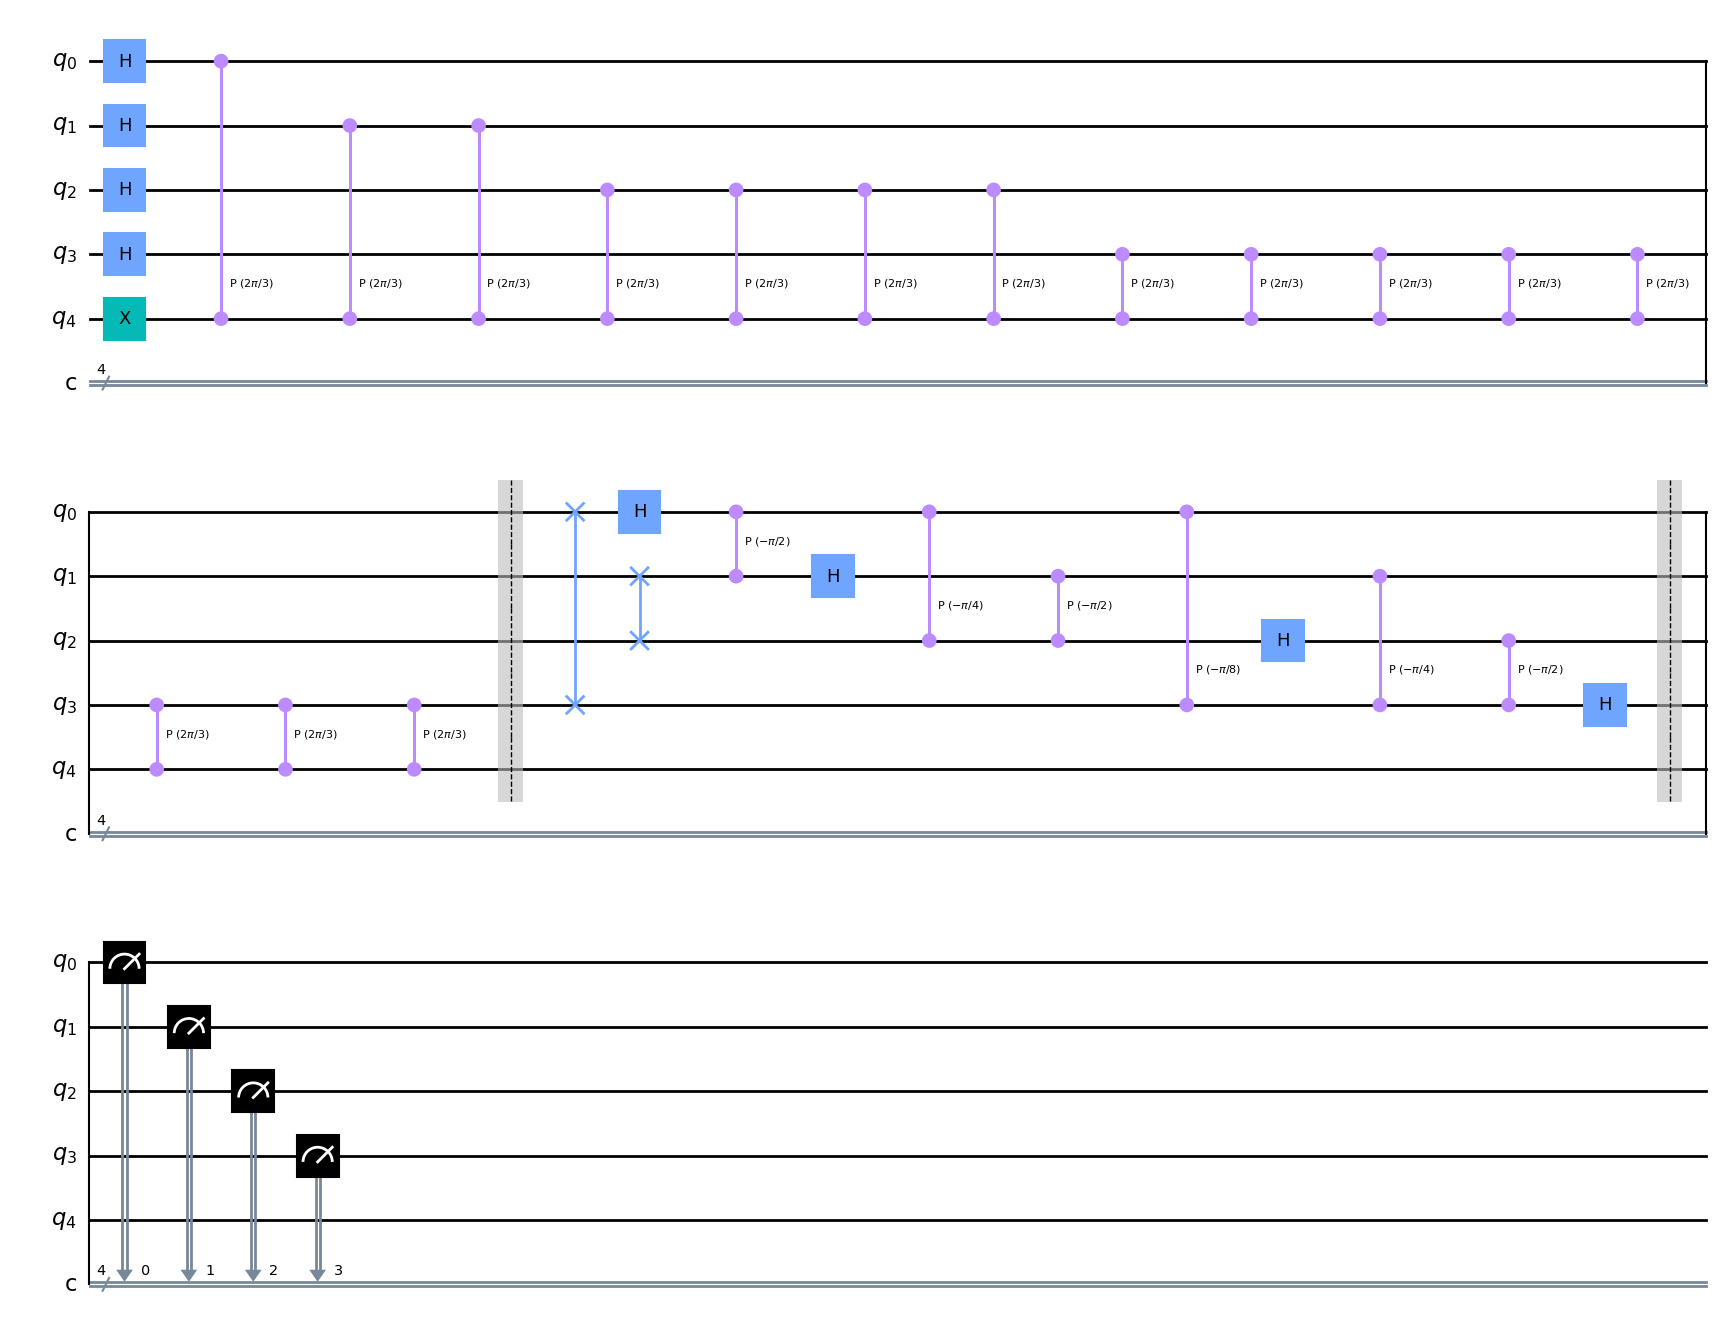

In [3]:

phase_register_size = 4
qpe4 = qk.QuantumCircuit(phase_register_size+1, phase_register_size)

### Insert your code here

theta = 2*np.pi/3
#set-up
# Prepare the initial state |psi⟩ = |1⟩
qpe4.x(phase_register_size)  # Apply X gate to the last qubit

# Apply the Hadamard gates for the QPE circuit
for qubit in range(phase_register_size):
    qpe4.h(qubit)
    

repetitions = 1
for counting_qubit in range(phase_register_size):
    for i in range(repetitions):
        qpe4.cp(theta, counting_qubit, phase_register_size); # controlled-T

    repetitions *= 2
qpe4.barrier()

 # Apply the inverse Quantum Fourier Transform (QFT) on the phase register
qft_dagger(qpe4, phase_register_size)
qpe4.barrier()

# Measure the phase register
qpe4.measure(range(phase_register_size), range(phase_register_size))
    



qpe4.draw()





Now use the `AerSimulator` to simulate this circuit and plot the histogram of the results.  Use 2000 shots.


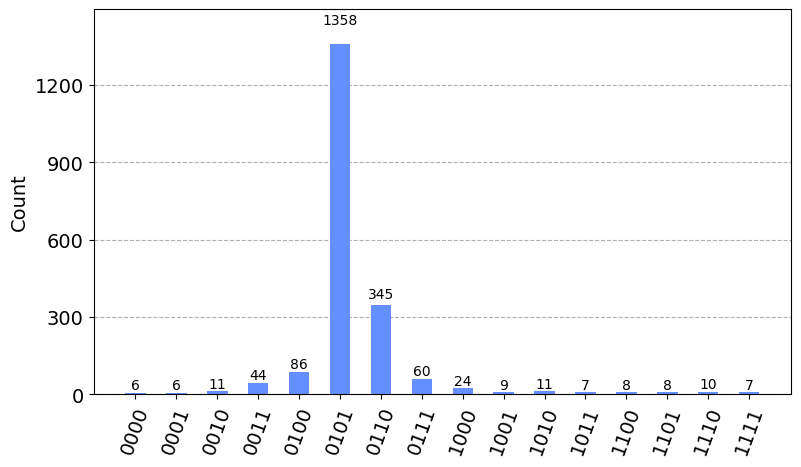

In [4]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
sim = qk.Aer.get_backend('aer_simulator')
shots = 2000
count_qpe4 = qk.execute(qpe4, sim, shots=shots).result().get_counts()
plot_histogram(count_qpe4, figsize=(9,5))

In [5]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex1 

grade_lab3_ex1(count_qpe4)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Next write a function to process the bit strings into the estimate of $\theta$.  Recall that the phase estimate is written in the form:

$$ \theta = 0.\theta_1\theta_2\theta_3...\theta_t = \frac{\theta_1}{2^1} + \frac{\theta_2}{2^2} + \frac{\theta_3}{2^3} + ... + \frac{\theta_t}{2^t} $$

where $\theta_i = \{0,1\}$.  What is the estimated phase?  To within what power of 2 is the estimate accurate up to given your choice of the number of counting qubits (e.g. $2^{-2}$, $2^{-3}$, $2^{-4}$, etc.)?



In [6]:
#Grab the highest probability measurement
max_binary_counts = 0
max_binary_val = ''
for key, item in count_qpe4.items():
    if item > max_binary_counts:
        max_binary_counts = item
        max_binary_val = key

## Your function to convert a binary string to decimal goes here
def binary_to_decimal(binary_string):
    decimal = int(binary_string, 2)
    return decimal

# Convert the binary string to decimal
decimal_val = binary_to_decimal(max_binary_val)

n_qubits=phase_register_size
# Calculate the estimated phase
estimated_phase = decimal_val / 2**phase_register_size  # n_qubits is the number of counting qubits

# Calculate the phase accuracy
phase_accuracy = 1 / 2**phase_register_size  # n_qubits is the number of counting qubits


print(estimated_phase)

0.3125


In [7]:

from qc_grader.challenges.qgss_2023 import grade_lab3_ex2 

grade_lab3_ex2([estimated_phase, phase_accuracy])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 2: Run on Noisy Hardware

Now run this circuit using your favorite backend!  Transpile this circuit a number of times (you pick how many) and pick the one with the lowest and highest circuit depth. 

Transpile the circuit with the parameter optimization_level = 3 to reduce the error in the result. Qiskit by default uses a stochastic swap mapper to place the needed SWAP gates, which varies the transpiled circuit results even under the same runtime settings. Therefore, to achieve shorter depth transpiled circuit for smaller error in the outcome, transpile qpe4 multiple times and choose one with the minimum circuit depth. Select the maximum circuit depth one as well to compare against, name them `min_depth_qpe` and `max_depth_qpe`.



In [8]:
from qiskit_ibm_provider import IBMProvider
from qiskit.compiler import transpile
from qiskit.circuit.library import RXGate, RYGate, RZGate


provider = IBMProvider()
hub = "summer-school-ea"
group = "group-3"
project = "648fee6158247483"
backend_name = 'ibmq_qasm_simulator'

backend = provider.get_backend(backend_name)

# your code goes here
def add_random_gates(circuit):
    qr = circuit.qregs[0]
    for qubit in qr:
        theta = np.random.uniform(0, 2 * np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        lam = np.random.uniform(0, 2 * np.pi)
        circuit.append(RXGate(theta), [qubit])
        circuit.append(RYGate(phi), [qubit])
        circuit.append(RZGate(lam), [qubit])
    return circuit

min_depth = float('inf')
max_depth = 0
num_runs = 10  # Choose the number of transpilation runs


# Transpile the circuit multiple times and select the min/max depth
for i in range(num_runs):
    transpiled_circuit = transpile(add_random_gates(qpe4), backend=backend, optimization_level=0)
    depth=transpiled_circuit.depth()
    if depth < min_depth:
        min_depth = depth
        min_depth_qpe = transpiled_circuit
    if depth > max_depth:
        max_depth = depth
        max_depth_qpe = transpiled_circuit

        

print(min_depth)
print(max_depth)


28
55


cjjhl6c4jk0qbkri421g


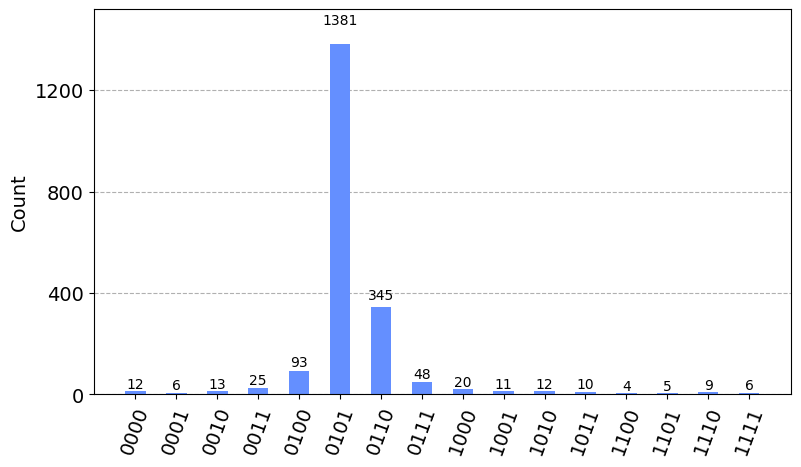

In [9]:
shots = 2000

#Run the minimum depth qpe circuit
job_min_qpe4 = backend.run(min_depth_qpe, sim, shots=shots)
print(job_min_qpe4.job_id())

#Gather the count data
count_min_qpe4 = job_min_qpe4.result().get_counts()
plot_histogram(count_min_qpe4, figsize=(9,5))

cjjhl7cvcjlre5bdj470


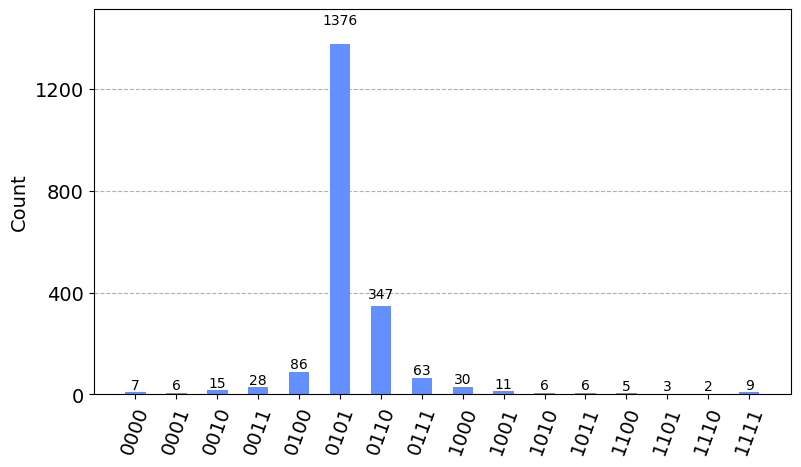

In [10]:

#Run the maximum depth qpe circuit
job_max_qpe4 = backend.run(max_depth_qpe, sim, shots=shots)
print(job_max_qpe4.job_id())

#Gather the count data
count_max_qpe4 = job_max_qpe4.result().get_counts()
plot_histogram(count_max_qpe4, figsize=(9,5))

In [11]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex3

grade_lab3_ex3([max_depth_qpe, min_depth_qpe])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 3: Try with a different $\theta$

Now try the same procedure with $\theta = \frac{1}{5}$.  Rewrite your code written above to create a function which generates a QPE circuit with $n$ register qubits.  How many register qubits storing the phase information are needed for the estimate to be accurate to within $2^{-3}$? 

*Hint: It may be easier to iterate over different phase register sizes by creating a callable function. Perhaps call it* `qpe_circuit`

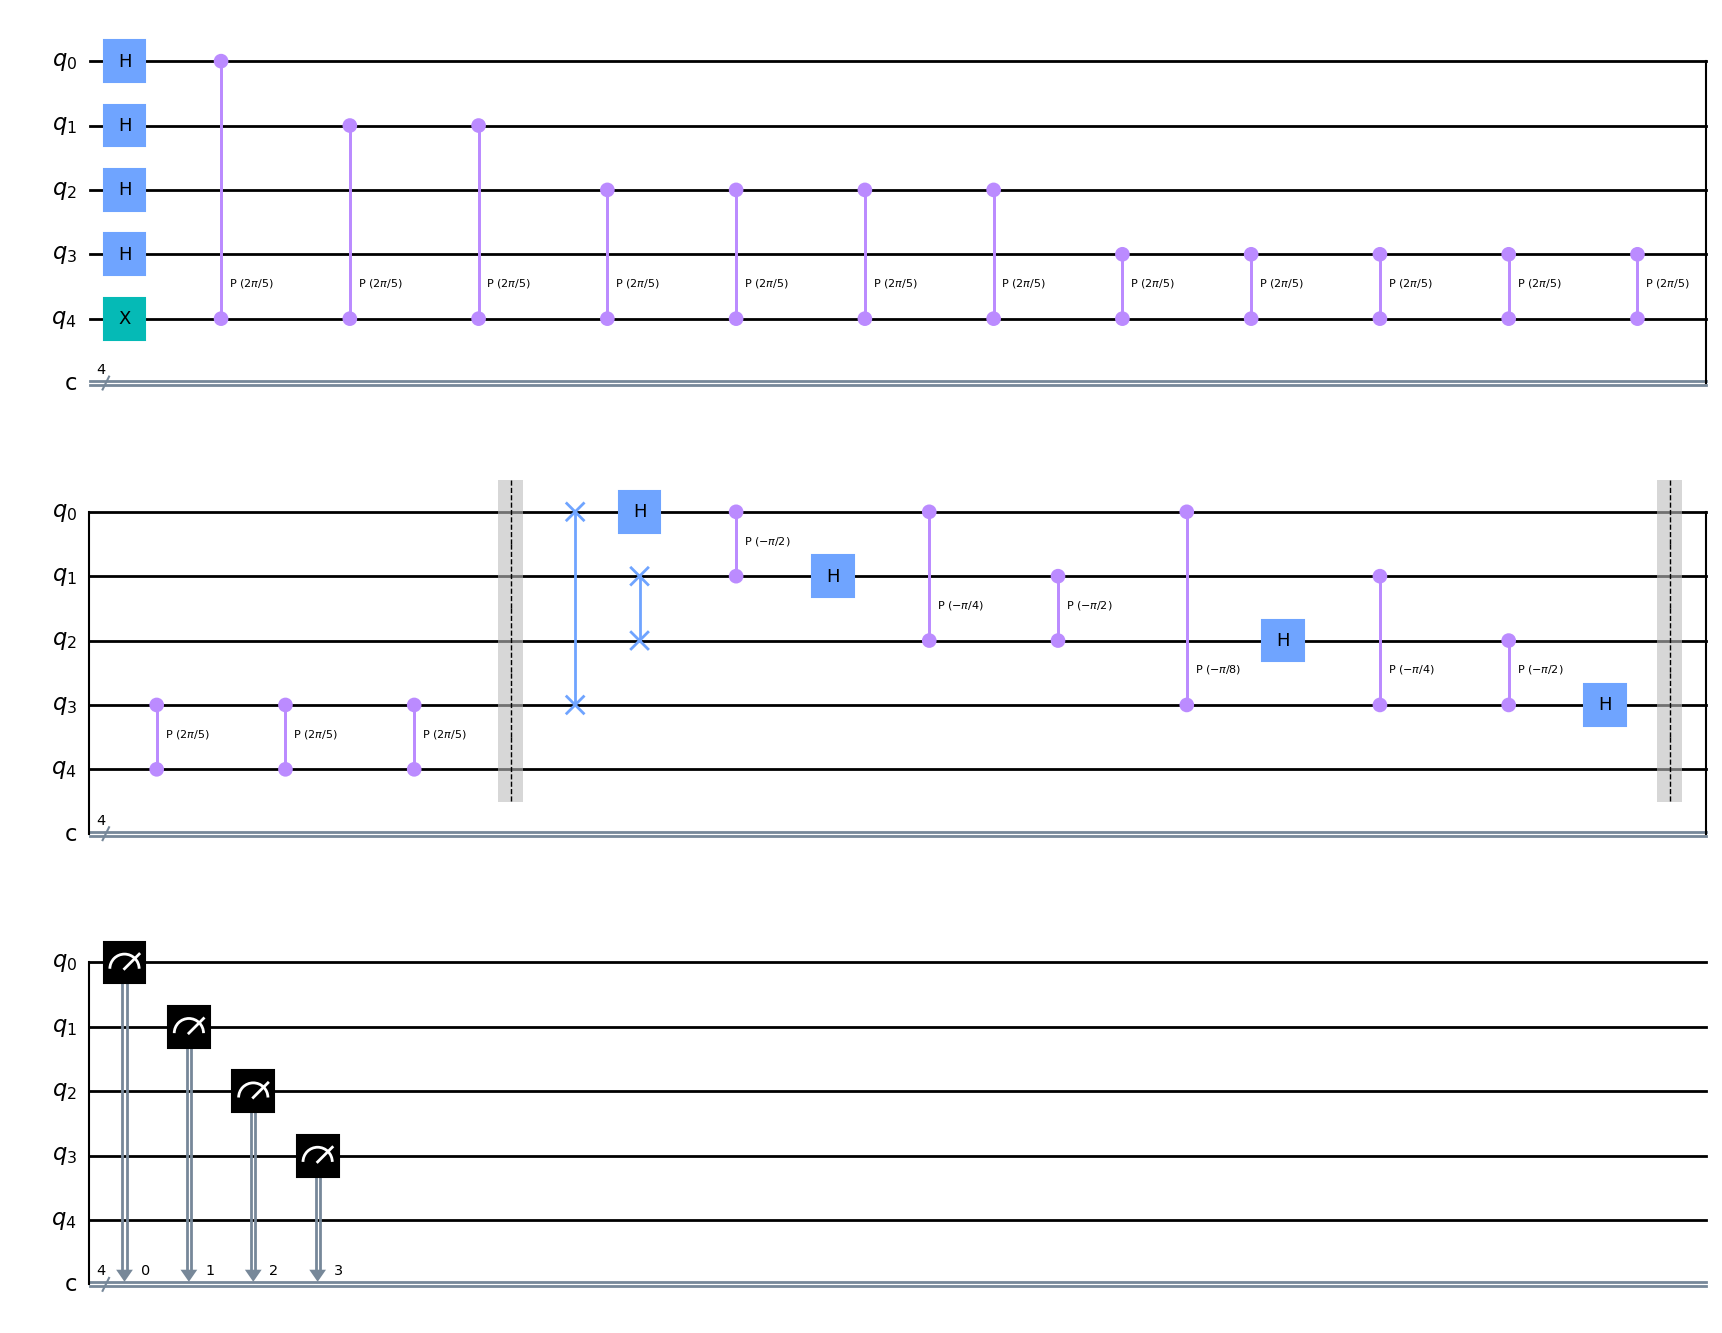

In [12]:

#phase_register_size = 4

def qpe_circuit(phase_register_size):
    qpe4 = qk.QuantumCircuit(phase_register_size+1, phase_register_size)

    ### Insert your code here

    theta = 2*np.pi/5
    #set-up
    # Prepare the initial state |psi⟩ = |1⟩
    qpe4.x(phase_register_size)  # Apply X gate to the last qubit

    # Apply the Hadamard gates for the QPE circuit
    for qubit in range(phase_register_size):
        qpe4.h(qubit)


    repetitions = 1
    for counting_qubit in range(phase_register_size):
        for i in range(repetitions):
            qpe4.cp(theta, counting_qubit, phase_register_size); # controlled-T

        repetitions *= 2
    qpe4.barrier()

     # Apply the inverse Quantum Fourier Transform (QFT) on the phase register
    qft_dagger(qpe4, phase_register_size)
    qpe4.barrier()

    # Measure the phase register
    qpe4.measure(range(phase_register_size), range(phase_register_size))
    
    return qpe4




qpe4= qpe_circuit(4)
qpe4.draw()





In [13]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
reg_size = 4# Vary the register sizes

def simulat(reg_size):
    qpe_check = qpe_circuit(reg_size)
    sim = qk.Aer.get_backend('aer_simulator')
    shots = 2000
    count_qpe4 = qk.execute(qpe_check, sim, shots=shots).result().get_counts()
    #plot_histogram(count_qpe4, figsize=(9,5))
    return count_qpe4
simulat(4)

{'1010': 1,
 '1111': 2,
 '1011': 3,
 '0011': 1771,
 '0111': 3,
 '0100': 107,
 '0001': 19,
 '0010': 36,
 '0000': 6,
 '1001': 3,
 '0101': 25,
 '1110': 3,
 '1100': 2,
 '1000': 4,
 '0110': 11,
 '1101': 4}

In [14]:
# Process the count data to determine accuracy of the estimated phase

def data_accuracy(count_qpe4):
    #Grab the highest probability measurement
    max_binary_counts = 0
    max_binary_val = ''
    for key, item in count_qpe4.items():
        if item > max_binary_counts:
            max_binary_counts = item
            max_binary_val = key

    ## Your function to convert a binary string to decimal goes here
    def binary_to_decimal(binary_string):
        decimal = int(binary_string, 2)
        return decimal

    # Convert the binary string to decimal
    decimal_val = binary_to_decimal(max_binary_val)

    n_qubits=4
    # Calculate the estimated phase
    estimated_phase = decimal_val / 2**n_qubits  # n_qubits is the number of counting qubits

    # Calculate the phase accuracy
    phase_accuracy = 1 / 2**n_qubits  # n_qubits is the number of counting qubits
    
    return phase_accuracy

for reg_size in [3,4,5,6,7,8,9,10]:
    
    count_qpe4=simulat(reg_size)
    data_accuracy(count_qpe4)
    print(phase_accuracy)


0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625


In [15]:
required_register_size = 5#your answer here

In [16]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex4

grade_lab3_ex4(required_register_size)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Section 2: Shor's Algorithm
***

Here we will construct a set of functions to implement Shor's algorithm.  Remember that the goal of this algorithm is to find the prime factors of some large number $N$ and the key speedup this algorithm provides is by executing the period-finding part using a quantum computer.  This is where this section of the lab will focus.

*What will students do?*:
1. Construct a compiled version of Shor's algorithm

Recall the Shor's algorithm is composed of the following steps:
1. Choose a co-prime $a$, where $a\in [2,N-1]$ and the greatest common divisor of $a$ and $N$ is 1.
1. Find the order (periodicity) of $a$ modulo $N$, i.e. the smallest integer $r$ such that $a^r\text{mod} N=1$
1. Obtain the factor of $N$ by computing the greatest common divisor of $a^{r/2} \pm 1$ and $N$.

## Step 1. Period Finding

To begin, we'll use the unitary operator: $$ U|y\rangle{} \equiv |ay\ \text{mod} N\rangle{} $$


and explore the superposition state: 
$$
|u\rangle{} = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{-\frac{2\pi ik}{r}}|a^k \text{mod}N\rangle{}
$$

Let's pick $a=3$ and $N=35$ as an example and investigate what the action of $U$ is on $|u\rangle{}$
\begin{align}
    U|u\rangle{} &= U\frac{1}{\sqrt{r}}\left( |1\rangle{} + e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} \right) \\
    & =\frac{1}{\sqrt{r}}\left( U|1\rangle{} + e^{-\frac{2\pi i}{r}}U|3\rangle{} + e^{\frac{-4\pi i}{r}}U|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}U|4\rangle{} + e^{\frac{-22\pi i}{r}}U|12\rangle{} \right) \\
    &= \frac{1}{\sqrt{r}}\left( |3\rangle{} + e^{-\frac{2\pi i}{r}}|9\rangle{} + e^{\frac{-4\pi i}{r}}|27\rangle{} + ... + e^{\frac{-20\pi i}{r}}|12\rangle{} + e^{\frac{-22\pi i}{r}}|1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}}\left( e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} + |1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}} |u\rangle{}.
\end{align}


This is a particularly helpful eigenvalue as it contains $r$.  In fact, it needs to be included in order to ensure the phase differences between the basis states are equal.  This is also not the only eigenstate of $U$.  FOr us to generalize further, we can multiply an integer $s$ to each of these phases, which will then show up in our eigenvalue

\begin{align}
    |u_s\rangle{} &= \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{\frac{-2\pi isk}{r}|a^k\text{mod} N\rangle{}} \\
    U|u_s\rangle{} &= e^{\frac{2\pi is}{r}}|u_s\rangle{}.
\end{align}


Now we have an eigenstate for each integer $0 \leq s \leq r$.  Notably, if we add up all of these eigenstates, the phases cancel all other basis states except $|1\rangle{}$ $$ \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1}|u_s\rangle{} = |1\rangle{} $$.


Since any state in the computational basis can be written as a linear combination of these eigenstates, if we do QPE on $U$ using the state $|1\rangle{}$, we will measure a phase 

$$ \phi = \frac{s}{r} $$
where $s$ is a random integer between $0$ and $r-1$.  Finally, we can use a method called the continued fraction algorithm on $\phi$ in order to find r.  The final circuit will look something like this



<img src="./resources/Shor_circuit.png" alt="Short Circuit" style="width: 1000px;"/>


***

Below we'll provide the unitary $U$ needed for solving this period finding problem with $a=7$ and $N=15$

$$ 
    U|y\rangle{} = |7y\text{mod}15\rangle{}.
$$

To create $U^x$ we will simply repeat the circuit $x$ times.  The cell below will construct this unitary

In [17]:
import qiskit as qk
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd

In [18]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = qk.QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

In [19]:
m

4

Confirm if the operator $U$ works as intended by creating a quantum circuit with $m$ qubits.  Prepare the inpute state representing any integer between $0$ and $15$ (remembering that Qiskit uses little endian notation) such as $|1\rangle{} = |0001\rangle{}$, $|5\rangle{} = |0101\rangle{}$, etc. and apply the $U$ gate to it.  Check if the circuit produces the expected outcomes for several inputs: $|1\rangle{}$, $|3\rangle{}$, and $|5\rangle{}$.  Run these circuits through the `aer_simulator` backend with $10000$ shots, save the count data as `input_1`, `input_3`, and `input_5`.

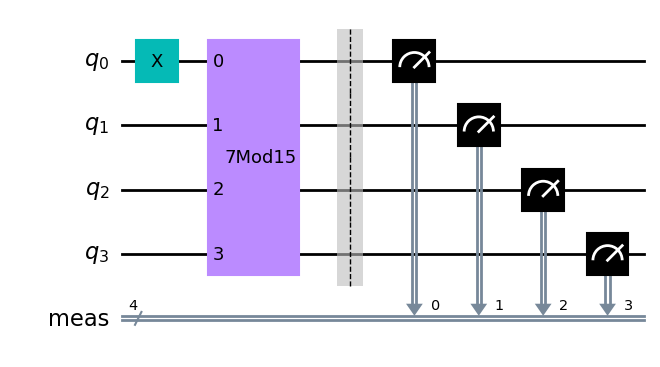

In [20]:
# ### your code goes here

qcirc = qk.QuantumCircuit(m)

qcirc1=qcirc.copy()
## Input state representing |1⟩ = |0001⟩
qcirc1.x(0)
qcirc1.append(U, range(m))
qcirc1.measure_all()
qcirc1.draw()

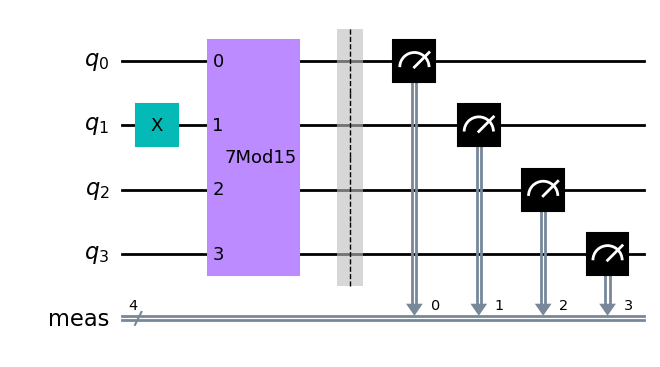

In [21]:

# #Input state |3⟩ = |0011⟩
qcirc2=qcirc.copy()
#qcirc2.x(0)
qcirc2.x(1)
qcirc2.append(U, range(m))

qcirc2.measure_all()
qcirc2.draw()

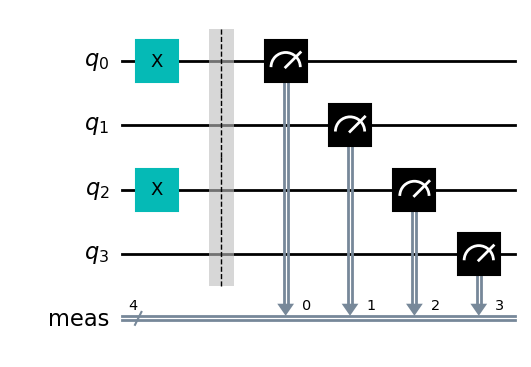

In [22]:
# Input state |5⟩ = |0101⟩
qcirc3=qcirc.copy()
qcirc3.x(0)
qcirc3.x(2)
qcirc2.append(U, range(m))
qcirc3.measure_all()
qcirc3.draw()

In [23]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
sim = qk.Aer.get_backend('aer_simulator')
shots = 20000
#count_qpe4 = qk.execute(qcirc, sim, shots=shots).result().get_counts()

input_1 = qk.execute(qcirc1, sim, shots=shots).result().get_counts()  # save the count data for input 1

input_3 = qk.execute(qcirc2, sim, shots=shots).result().get_counts()# save the count data for input 3
input_5 = qk.execute(qcirc3, sim, shots=shots).result().get_counts()# save the count data for input 5



In [24]:
print(input_1)
print(input_3)
print(input_5)

{'0111': 20000}
{'1110': 20000}
{'0101': 20000}


In [25]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex5

grade_lab3_ex5([input_1, input_3, input_5])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 2. Implementing $U^{2^{m-1}}$

Now we'll use this controlled-$U$ to estimate the phase $\phi=\frac{s}{r}$.  First create a quantum circuit with $m=4$ qubits implementing the `7mod15` gate $2^2$ times and run it on the `unitary_simulator` backend to obtain the matrix represenation of the gates in the circuit.  Verify $U^2=I$.

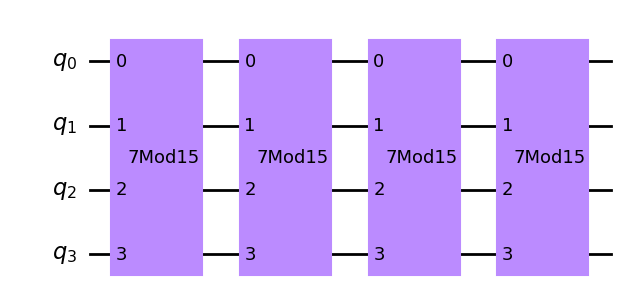

In [26]:

unitary_circ = qk.QuantumCircuit(m)

# Your code goes here
# Quantum circuit with 'm' qubits
m = 4
unitary_circ = qk.QuantumCircuit(m)

# Repeat the U gate 22 times
for _ in range(2**2):
    unitary_circ.append(U, range(m))

unitary_circ.draw()

In [27]:
sim = qk.Aer.get_backend('unitary_simulator')
unitary = qk.execute(unitary_circ, sim).result().get_unitary()


In [28]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex6

grade_lab3_ex6(unitary, unitary_circ)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 3. Finding $\phi$ and Continued Fractions


Now armed with a way to execute $U^{2^{m-1}}$, let's use it in the QPE circuit you created earlier.  Below is a function to construct a controlled-$U$ gate. Use $8$ phase register qubits and, using the `aer_simulator` again, estimate the phase $\phi$ given an input state of $|1\rangle{}$.

*Hint: at each step in the QPE circuit, you'll need to construct a new `cU_multi` circuit and append it to the QPE circuit. There will be several estimates that have approximately equal probability.*

<img src="./resources/Shor_circuit.png" alt="Short Circuit" style="width: 1000px;"/>


In [29]:
# # Create 8mod15 gate
# N = 15
# #m = int(np.ceil(np.log2(N)))
# # m=8

# U_qc = qk.QuantumCircuit(m)
# U_qc.x(range(m))
# U_qc.swap(1, 2)
# U_qc.swap(2, 3)
# U_qc.swap(0, 3)
# U_qc.swap(3, 4)  # Add this swap
# U_qc.swap(4, 5)  # Add this swap
# U_qc.swap(5, 6)  # Add this swap
# U_qc.swap(6, 7)  # Add this swap

# U = U_qc.to_gate()
# U.name = '{}Mod{}'.format(7, N)

# # Create the 8-qubit QuantumCircuit and ClassicalRegister
# q = qk.QuantumRegister(8)
# c = qk.ClassicalRegister(8)
# circ = qk.QuantumCircuit(q, c)

# # Apply the U gate to the first 8 qubits
# circ.append(U, range(8))
# circ.draw()

In [30]:
def cU_multi(k, m):
    #k= number of counting_qubits
    #m = number of control qubit
    circ = qk.QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)

    cU_multi = U_multi.control()
    return cU_multi

Cgate=cU_multi(8,4)
Cgate

Instruction(name='c7Mod15_[2^8]', num_qubits=5, num_clbits=0, params=[])

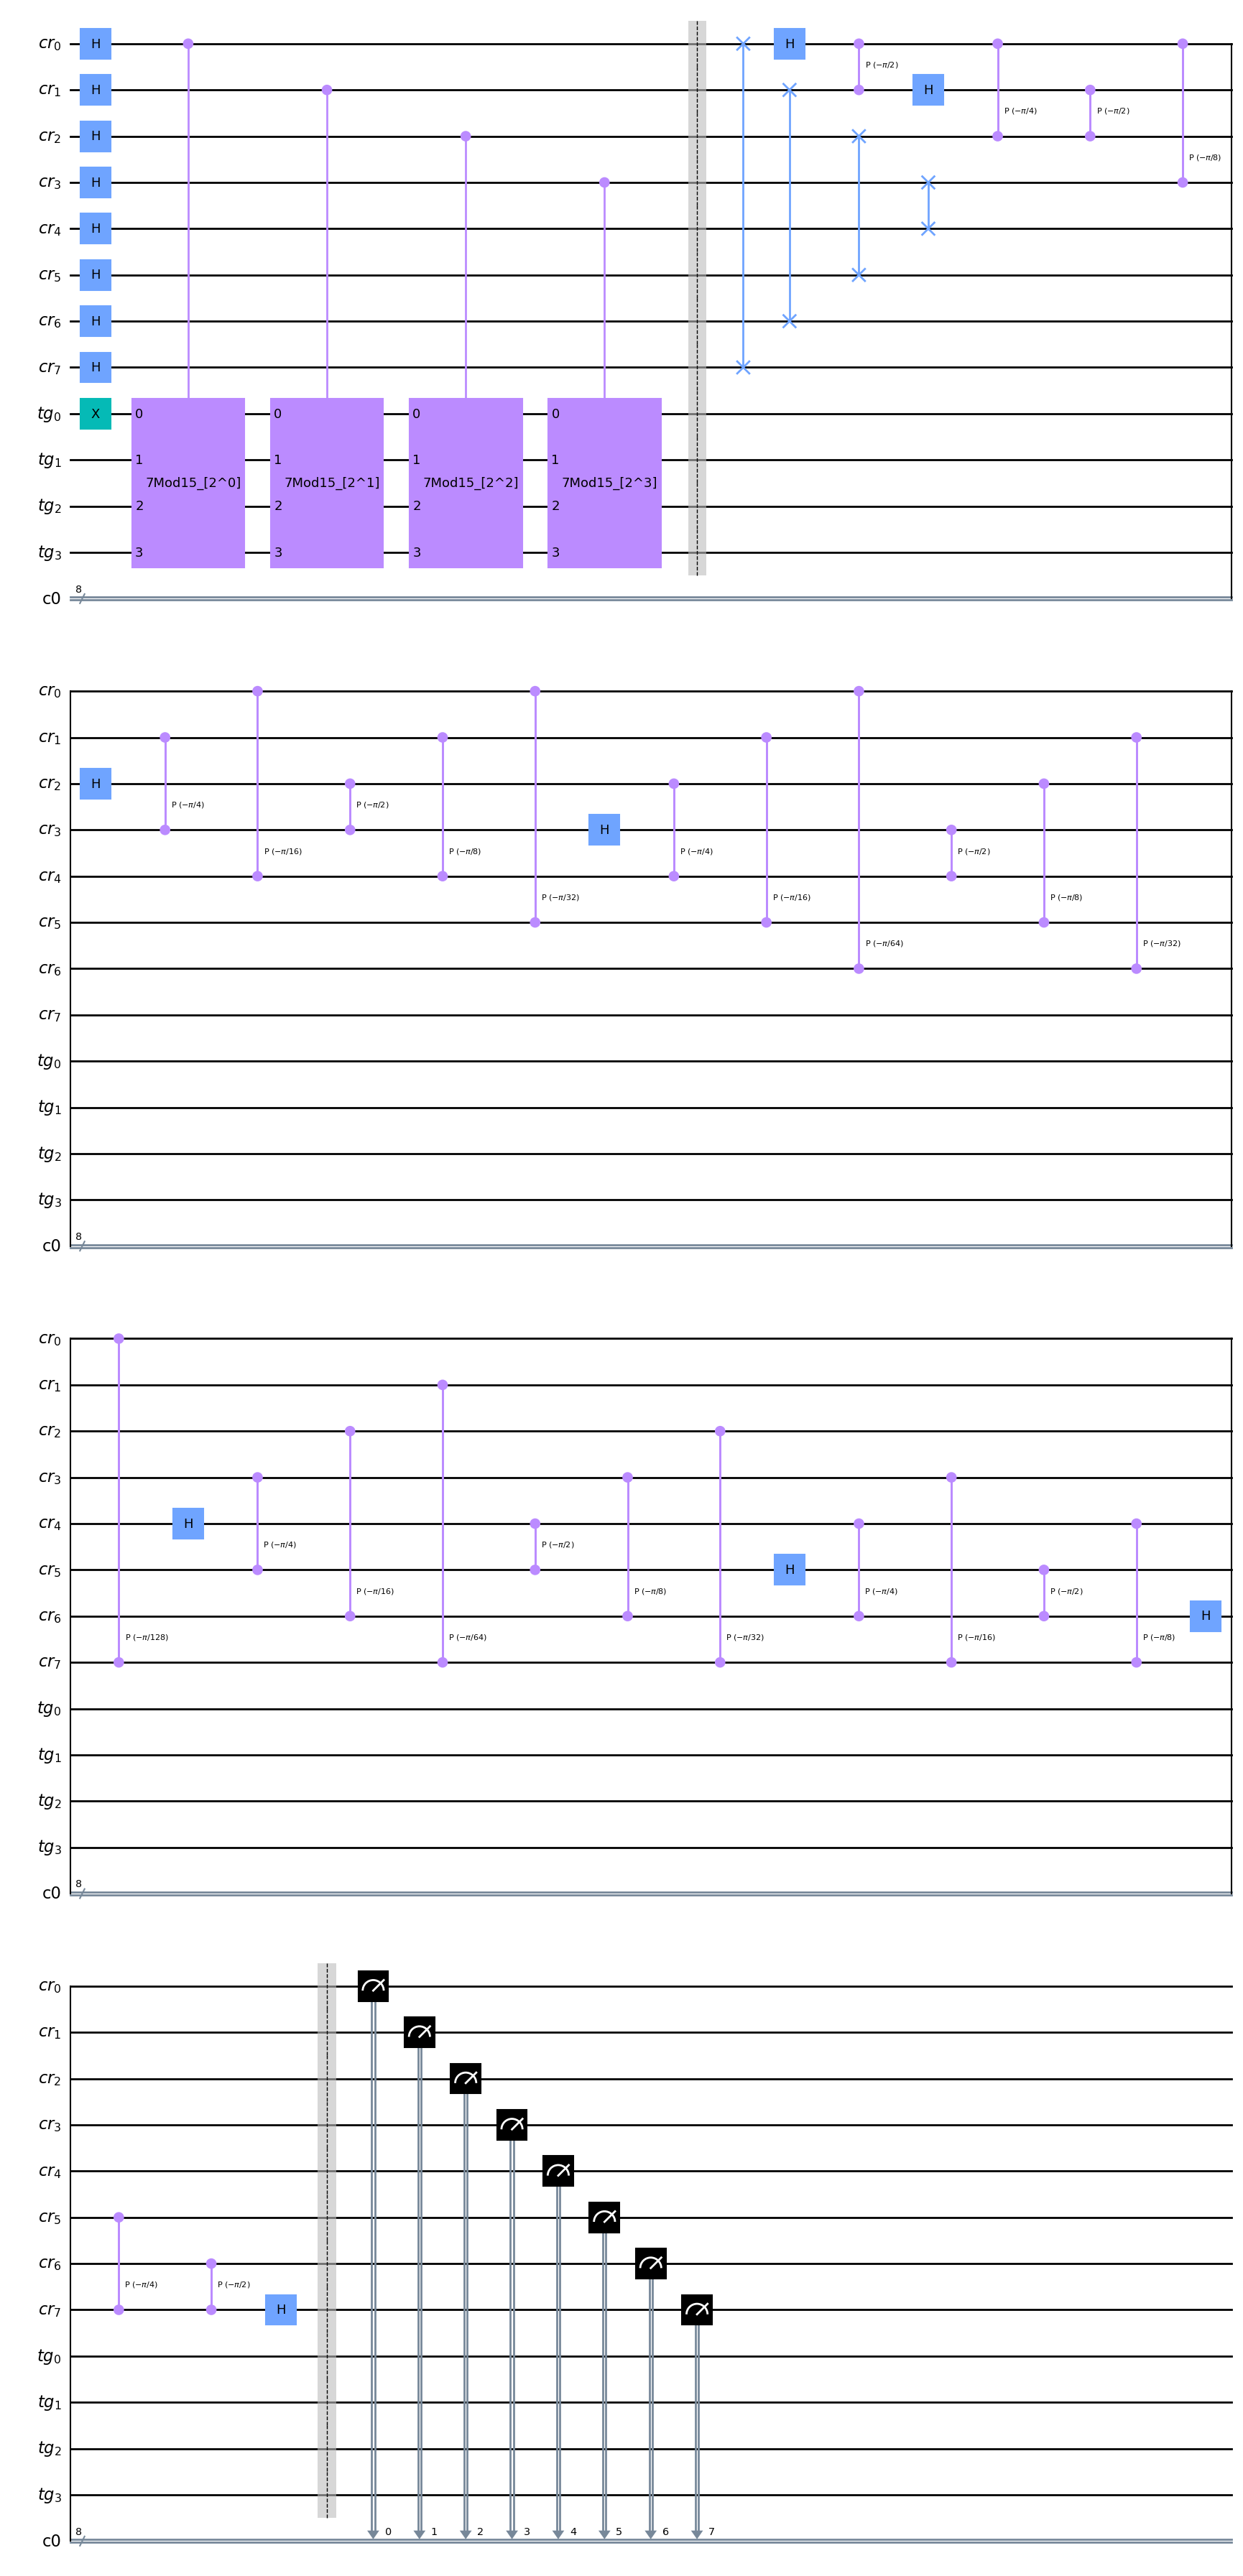

In [31]:
import numpy as np
import qiskit as qk
from qiskit.visualization import plot_histogram


# Number of phase register qubits
num_qubits = 4

# Number of control qubits for the controlled-U gate
num_control_qubits = 8

# Create the QuantumCircuit 'shor_qpe'
control_register = qk.QuantumRegister(num_control_qubits, 'cr')
target_register = qk.QuantumRegister(num_qubits,'tg')
classical_register = qk.ClassicalRegister(8)

shor_qpe = qk.QuantumCircuit(control_register, target_register, classical_register)


# # Apply Hadamard gates to the control qubits
shor_qpe.h(control_register)

# # Apply the input state preparation
shor_qpe.x(target_register[0])  # Apply |1⟩ input state


# # Apply the controlled-U gates for different time steps
for t in range(num_qubits):
      cU_gate = cU_multi(t, num_qubits)

      # Append the cU gate to the circuit
      shor_qpe.append(cU_gate,[list(control_register)[t]] + list(target_register))
shor_qpe.barrier()


 # Apply the inverse Quantum Fourier Transform (QFT) on the phase register
qft_dagger(shor_qpe, num_control_qubits)
shor_qpe.barrier()

# Measure the phase register
shor_qpe.measure(control_register, classical_register)
# # Simulate the circuit and obtain the counts
# sim = qk.Aer.get_backend('aer_simulator')
# shots = 20000
# shor_qpe_counts = qk.execute(shor_qpe, sim, shots=shots).result().get_counts()

# # Plot the histogram of the results
# plot_histogram(shor_qpe_counts, figsize=(9, 5))
shor_qpe.draw()


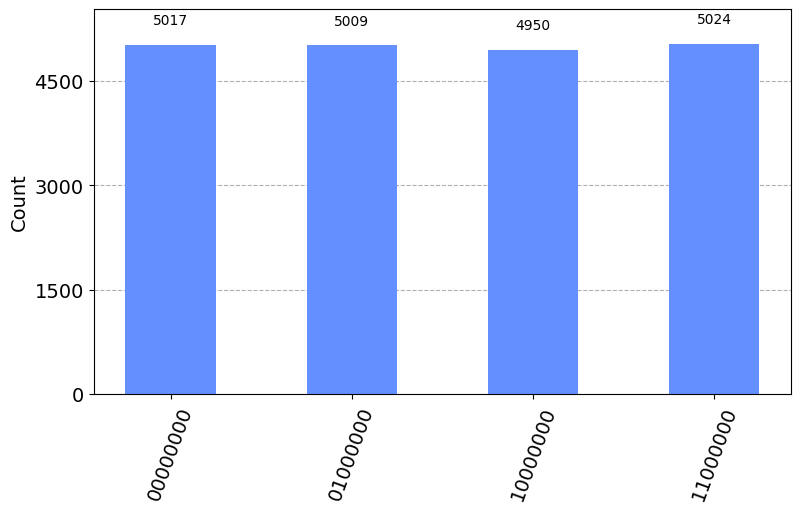

In [32]:
## Run this cell to simulate 'shor_qpe' and to plot the histogram of the results
sim = qk.Aer.get_backend('aer_simulator')
shots = 20000
shor_qpe_counts = qk.execute(shor_qpe, sim, shots=shots).result().get_counts()
plot_histogram(shor_qpe_counts, figsize=(9,5))

In [33]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex7

grade_lab3_ex7(shor_qpe_counts)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


We can then find the integers $s$ and $r$ using the continued fractions algorithm.  Luckily python has built-in functionality for this using the `Fraction` function, where we will limit the denominator to $r<15$.  Use this to find the estimated $s$ and $r$ for each outcome you measured above.

In [34]:
from fractions import Fraction
print(Fraction(0.666), '\n')
print(Fraction(0.666).limit_denominator(15))

5998794703657501/9007199254740992 

2/3


In [35]:
Fraction?

Init signature: Fraction(numerator=0, denominator=None, *, _normalize=True)
Docstring:     
This class implements rational numbers.

In the two-argument form of the constructor, Fraction(8, 6) will
produce a rational number equivalent to 4/3. Both arguments must
be Rational. The numerator defaults to 0 and the denominator
defaults to 1 so that Fraction(3) == 3 and Fraction() == 0.

Fractions can also be constructed from:

  - numeric strings similar to those accepted by the
    float constructor (for example, '-2.3' or '1e10')

  - strings of the form '123/456'

  - float and Decimal instances

  - other Rational instances (including integers)
File:           /opt/conda/lib/python3.10/fractions.py
Type:           ABCMeta
Subclasses:     


In [36]:

#shor_qpe_fractions =  # create a list of Fraction objects for each measurement outcome

shor_qpe_fractions = []

for outcome, count in shor_qpe_counts.items():
    decimal_outcome = int(outcome, 2)
    fraction = Fraction(decimal_outcome / (2 ** num_control_qubits)).limit_denominator(15)
    shor_qpe_fractions.append(fraction)

print(shor_qpe_fractions)


[Fraction(1, 4), Fraction(0, 1), Fraction(1, 2), Fraction(3, 4)]


In [37]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex8

grade_lab3_ex8(shor_qpe_fractions)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 4. Putting it all together

Now let's put all of these steps together in order to factor the (very simple) number,  $N = 15$.  We'll continue with our example of $a=7$, remember that the phase we measure $s/r$ where $s$ is a random integer between $0$ and $r-1$ and:

$$
    a^r\text{mod}N = 1
$$

Then, once we have $r$, we can find a factor of $N$ by:

$$
    \left(a^r-1\right)\text{mod} N = 0
$$
which requires that $N$ must divide by $a^r-1$.  If $r$ is even, we can also write

$$
    a^r-1 = \left(a^{r/2}+1\right)\left(a^{r/2}-1\right).
$$

Put together a function called `shor_qpe` which takes arguments for $a$ (a random co-prime where $a\in [2,N-1]$) and $k$ (the number of counting qubits) and composes, runs, and processes Shor's algorithm to guess the factors.

In [39]:
def shor_qpe(a, k):


    #Step 1. Begin a while loop until a nontrivial guess is found
    ### Your code goes here ###


        #Step 2a. Construct a QPE circuit with m phase count qubits
        #  to guess the phase phi = s/r using the function cU_multi()
        ### Your code goes here ###


        #Step 2b. Run the QPE circuit with a single shot, record the results
        # and convert the estimated phase bitstring to decimal
        ### Your code goes here ###


        #Step 3. Use the Fraction object to find the guess for r
        ### Your code goes here ###


        #Step 4. Now that r has been found, use the builtin greatest common deonominator
        # function to determine the guesses for a factor of N
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]

        #Step 5. For each guess in guesses, check if at least one is a non-trivial factor
        # i.e.  (guess != 1 or N) and (N % guess == 0)
        ### Your code goes here ###
    
    #Step 6. If a nontrivial factor is found return the list 'guesses', otherwise
    # continue the while loop
    ### Your code goes here ###
    
    return guesses

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 34)

In [ ]:
import numpy as np
import qiskit as qk
from qiskit.visualization import plot_histogram
from fractions import Fraction

def shor_qpe(a, k):
    N = 15  # The number to be factored
    num_qubits = k  # Number of phase register qubits
    num_control_qubits = 2 * k  # Number of control qubits for the controlled-U gate

    #Step 1. Begin a while loop until a nontrivial guess is found
    ### Your code goes here ###
    while True:
        
        
        # Step 2a. Construct a QPE circuit with m phase count qubits
        # to guess the phase phi = s/r using the function cU_multi()
        control_register = qk.QuantumRegister(num_control_qubits, 'cr')
        target_register = qk.QuantumRegister(num_qubits, 'tg')
        classical_register = qk.ClassicalRegister(num_control_qubits)

        shor_qpe_circuit = qk.QuantumCircuit(control_register, target_register, classical_register)


        # # Apply Hadamard gates to the control qubits
        shor_qpe_circuit.h(control_register)

        # # Apply the input state preparation
        shor_qpe_circuit.x(target_register[0])  # Apply |1⟩ input state


        # # Apply the controlled-U gates for different time steps
        for t in range(num_qubits):
              cU_gate = cU_multi(t, num_qubits)

              # Append the cU gate to the circuit
              shor_qpe_circuit.append(cU_gate,[list(control_register)[t]] + list(target_register))
        shor_qpe_circuit.barrier()


         # Apply the inverse Quantum Fourier Transform (QFT) on the phase register
        qft_dagger(shor_qpe_circuit, num_control_qubits)
        shor_qpe_circuit.barrier()

        # Measure the phase register
        shor_qpe_circuit.measure(control_register, classical_register)
        
        #display(shor_qpe_circuit.draw())
        
        
        

        # Step 2b. Run the QPE circuit with a single shot, record the results
        # and convert the estimated phase bitstring to decimal
        sim = qk.Aer.get_backend('aer_simulator')
        shots = 2000
        shor_qpe_counts = qk.execute(shor_qpe_circuit, sim, shots=shots).result().get_counts()
        
        #convert the estimated phase bitstring to decimal
        #Grab the highest probability measurement
        max_binary_counts = 0
        max_binary_val = ''
        for key, item in shor_qpe_counts.items():
            if item > max_binary_counts:
                max_binary_counts = item
                max_binary_val = key

        ## Your function to convert a binary string to decimal goes here
        def binary_to_decimal(binary_string):
            decimal = int(binary_string, 2)
            return decimal

        # Convert the binary string to decimal
        decimal_val = binary_to_decimal(max_binary_val)

        n_qubits=num_qubits
        # Calculate the estimated phase
        estimated_phase = decimal_val / 2**phase_register_size  # n_qubits is the number of counting qubits
        
        
        # sim = qk.Aer.get_backend('aer_simulator')
        # shor_qpe_counts = qk.execute(shor_qpe_circuit, sim, shots=1).result().get_counts()
        # phase_outcome = list(shor_qpe_counts.keys())[0]
        # decimal_phase = int(phase_outcome, 2)
        # phase_fraction = Fraction(decimal_phase / (2 ** num_control_qubits)).limit_denominator(15)


        # Step 3. Use the Fraction object to find the guess for r
        phase_fraction = Fraction(estimated_phase).limit_denominator(15)
        r_guess = phase_fraction.denominator

        # Step 4. Now that r has been found, use the builtin greatest common denominator
        # function to determine the guesses for a factor of N
        guesses = [np.gcd(a**(r_guess//2) - 1, N), np.gcd(a**(r_guess//2) + 1, N)]

        # Step 5. For each guess in guesses, check if at least one is a non-trivial factor
        if (guesses[0] != 1 and guesses[0] != N) and (guesses[1] != 1 and guesses[1] != N):
            return guesses
        #return guesses

# Example usage
a = 4  # A random co-prime where a∈[2, N-1]
k = 4  # Number of counting qubits
N=15

factors = shor_qpe(a, k)
print(f"Factors of {N}:", factors)

In [ ]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex9

grade_lab3_ex9(shor_qpe)


Congratulations! You've completed Lab 3 of the Global Summer School!! 🎉

This lab was adapted from both the [Qiskit QPE Lab](https://learn.qiskit.org/course/ch-labs/lab-5-accuracy-of-quantum-phase-estimation#lab-3-0) as well as the [Qiskit Shor's Algorithm](https://learn.qiskit.org/course/ch-labs/lab-7-scalable-shors-algorithm) lab